## Description of Problem and Analysis
Dataset is from an e-commerce site. Someone at the company noticed Spain-based users have a much higher conversion rate than
any other Spanish-speaking country. One thought for why this was happening was translation. All Spanish speaking
countries had the same translation of the site which was written by a Spaniard. They
agreed to try a test where each country would have its one translation written by a local.
After running the test, they were really surprised to find that the test is negative. I.e., it
appears that the non-localized translation was doing better!

Goals:
* Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
* Explain why that might be happening. Are the localized translations really worse?
* If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

## Steps I took:
1. Join data & describe (summary)
2. Split data by Spain vs not-Spain & describe again. Check for similar distribution of other variables (blocking)
3. Compare conversion rate: Spain, non-Spain: test, not-test
4. Compare test and non-test conversion rates for all countries in LatAm
5. Hypothesis test (z-test) for difference of proportions between test and non-test in LatAm
6. Check conversion rate (test & non-test) trend over time
7. Decision Tree Analysis to detect bias in A/B Test sampling
8. Hypothesis test (z-test) for difference of proportions, split by country


In [4]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import tree
import graphviz

%matplotlib inline

### 1. Join data & describe (summary)

In [5]:
test_table = pd.read_csv('test_table.csv')
user_table = pd.read_csv('user_table.csv')

In [6]:
test_table.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [7]:
user_table.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [8]:
test_table.describe(include='all')

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
count,453321.000000,453321,453321,453321,453321,181877,453321,453321.000000,453321.000000
unique,NaN,5,3,2,3,5,7,NaN,NaN
top,NaN,2015-12-04,Ads,Web,ES,Facebook,Android_App,NaN,NaN
freq,NaN,141163,181877,251565,377547,68425,155135,NaN,NaN
mean,499937.514728,NaN,NaN,NaN,NaN,NaN,NaN,0.049579,0.476446
std,288665.193436,NaN,NaN,NaN,NaN,NaN,NaN,0.217073,0.499445
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,249816.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
50%,500019.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
75%,749522.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000


In [9]:
print(test_table.user_id.nunique() == test_table.user_id.count())
print(user_table.user_id.nunique() == user_table.user_id.count())
print(user_table.user_id.nunique() == test_table.user_id.nunique())

True
True
False


In [10]:
user_table.user_id.count() - test_table.user_id.count()

-454

There are some users in the test table that don't show up in the user table (we don't have info on their age, sex, or country). That's ok, we just need to account for this to keep these rows by outerjoining when we join the tables.

In [11]:
test_table.date.value_counts()

2015-12-04    141163
2015-12-03     99493
2015-11-30     71025
2015-12-01     70991
2015-12-02     70649
Name: date, dtype: int64

In [12]:
df = pd.merge(user_table, test_table, on='user_id',how='right')
df.head()

,user_id,sex,age,country,date,source,device,browser_language,ads_channel,browser,conversion,test
0,765821,M,20.0,Mexico,2015-12-02,Ads,Mobile,ES,Yahoo,Android_App,0,1
1,343561,F,27.0,Nicaragua,2015-12-04,Ads,Web,ES,Facebook,Safari,0,0
2,118744,M,23.0,Colombia,2015-11-30,Ads,Mobile,ES,Facebook,Android_App,0,1
3,987753,F,27.0,Venezuela,2015-12-04,SEO,Web,ES,NaN,IE,0,1
4,554597,F,20.0,Spain,2015-12-04,Direct,Web,ES,NaN,Chrome,0,0


### 2. Split data by Spain vs not-Spain & describe again. Check for similar distribution of other variables (blocking)

In [13]:
df['spain'] = np.where(df['country']=='Spain', 1, 0)
df.head()

,user_id,sex,age,country,date,source,device,browser_language,ads_channel,browser,conversion,test,spain
0,765821,M,20.0,Mexico,2015-12-02,Ads,Mobile,ES,Yahoo,Android_App,0,1,0
1,343561,F,27.0,Nicaragua,2015-12-04,Ads,Web,ES,Facebook,Safari,0,0,0
2,118744,M,23.0,Colombia,2015-11-30,Ads,Mobile,ES,Facebook,Android_App,0,1,0
3,987753,F,27.0,Venezuela,2015-12-04,SEO,Web,ES,NaN,IE,0,1,0
4,554597,F,20.0,Spain,2015-12-04,Direct,Web,ES,NaN,Chrome,0,0,1


In [14]:
df[df.spain==0].describe(include='all')

,user_id,sex,age,country,date,source,device,browser_language,ads_channel,browser,conversion,test,spain
count,401539.000000,401085,401085.00000,401085,401539,401539,401539,401539,160984,401539,401539.000000,401539.000000,401539.0
unique,NaN,2,NaN,16,5,3,2,3,5,7,NaN,NaN,NaN
top,NaN,M,NaN,Mexico,2015-12-04,Ads,Web,ES,Facebook,Android_App,NaN,NaN,NaN
freq,NaN,234080,NaN,128484,125033,160984,222728,334401,60520,137513,NaN,NaN,NaN
mean,499889.078124,NaN,27.12815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045692,0.537888,0.0
std,288708.317953,NaN,6.77476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.208816,0.498563,0.0
min,1.000000,NaN,18.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0
25%,249802.500000,NaN,22.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.0
50%,499980.000000,NaN,26.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.0
75%,749580.500000,NaN,31.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.0


In [15]:
df[df.spain==1].describe(include='all')

,user_id,sex,age,country,date,source,device,browser_language,ads_channel,browser,conversion,test,spain
count,51782.000000,51782,51782.000000,51782,51782,51782,51782,51782,20893,51782,51782.000000,51782.0,51782.0
unique,NaN,2,NaN,1,5,3,2,3,5,7,NaN,NaN,NaN
top,NaN,M,NaN,Spain,2015-12-04,Ads,Web,ES,Facebook,Android_App,NaN,NaN,NaN
freq,NaN,30405,NaN,51782,16130,20893,28837,43146,7905,17622,NaN,NaN,NaN
mean,500313.112143,NaN,27.150805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.079719,0.0,1.0
std,288333.077966,NaN,6.791548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.270860,0.0,0.0
min,26.000000,NaN,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,1.0
25%,249953.500000,NaN,22.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,1.0
50%,500273.000000,NaN,26.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,1.0
75%,749051.250000,NaN,31.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,1.0


### 3. Compare conversion rate: Spain, non-Spain: test, not-test

In [16]:
df.groupby(['spain','test']).conversion.mean()

spain  test
0      0       0.048330
       1       0.043425
1      0       0.079719
Name: conversion, dtype: float64

Spain is indeed showing much higher conversion than the others

### 4. Compare test and non-test conversion rates for all countries in LatAm

In [17]:
df[df.spain == 0].groupby(['country', 'test']).conversion.mean().unstack()

test,0,1
country,,
Argentina,0.015071,0.013725
Bolivia,0.049369,0.047901
Chile,0.048107,0.051295
Colombia,0.052089,0.050571
Costa Rica,0.052256,0.054738
Ecuador,0.049154,0.048988
El Salvador,0.053554,0.047947
Guatemala,0.050643,0.048647
Honduras,0.050906,0.047540


Conversion seems to be fairly similar between test and non-test samples. Some countries are doing slightly worse in test, and some are slightly better. We will need to do some hypothesis testing since it is not obvious to the naked eye.

### 5. Hypothesis test (z-test) for difference of proportions between test and non-test in LatAm

After looking around a bit, I couldn't find a great option for doing a z-test for difference in proportions using scipy.stats package and I also wanted to be sure I knew what was happening behind the scenes, so I wrote my own simple function to do this below:

In [18]:
def prop_test(n1,n2,p1,p2):
    '''Hypothesis test to test difference in proportions'''
    #pooled sample proportion
    p = (n1 * p1 + n2 * p2) / (n1 + n2)
    #standard error
    SE = np.sqrt(p * (1 - p) * ((1 / n1) + (1 / n2)))
    #z test statistic
    z = (p1 - p2) / SE
    #p-value - lots of ways to calculate from z, but I used the survival function of the normal distribution
    p_value = stats.norm.sf(abs(z))
    return p_value

In [19]:
g = df[df.spain==0].groupby('test').conversion.agg(['count', 'mean'])
g

,count,mean
test,,
0,185556,0.048330
1,215983,0.043425


In [20]:
#non-test group has conversion rate this much higher than test group
0.048330 / 0.043425

1.1129533678756476

In [21]:
p1 = g.iloc[0,1]
p2 = g.iloc[1,1]
n1 = g.iloc[0,0]
n2 = g.iloc[1,0]
p = prop_test(n1,n2,p1,p2)
p

5.7673075407624275e-14

P-value is very small so it follows that we can reject the null hypothesis (that there was no difference in conversion rate between test and non-test) from this z-test. The observed difference in conversion rate shows that the non-test (Spain translation) site had a conversion rate that was 11% higher than the localized site. That's a fairly large effect.

Something still doesn't seem right. Next step is to dig deeper into the other variables that could be affecting conversion rate. One thought is to check conversion over time - was there a big swing during one day?

### 6. Check conversion rate (test & non-test) trend over time

In [22]:
c = df[df.country!='Spain'].groupby(['date', 'test']).conversion.mean()
c = c.unstack()
c = c.rename(index = str, columns = {0: 'not-test', 1: 'test'})
c["ratio"] = c.test/c['not-test']
conversion_by_date = c
conversion_by_date

test,not-test,test,ratio
date,,,
2015-11-30,0.051378,0.043886,0.854179
2015-12-01,0.046287,0.041387,0.894141
2015-12-02,0.048550,0.044234,0.911090
2015-12-03,0.049284,0.043884,0.890439
2015-12-04,0.047043,0.043491,0.924486


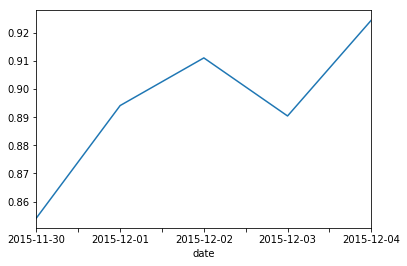

In [23]:
conversion_by_date.ratio.plot()

Fairly normal trend - no large flucuations. One quick way to check that the other variables are blocked (by random assignment) is to try to fit a decision tree. Any split would indicate an imbalance in one particular variable as it relates to whether or not that data was selected for the A/B Test group or not.

### 7. Decision Tree Analysis to detect bias in A/B Test sampling

One thing about sklearn.tree is that it doesn't handle null values, so I will strip those out

In [26]:
df_test = df[df.country!='Spain']
df_test.isnull().sum()

user_id                  0
sex                    454
age                    454
country                454
date                     0
source                   0
device                   0
browser_language         0
ads_channel         240555
browser                  0
conversion               0
test                     0
spain                    0
dtype: int64

In [27]:
df_test = df_test[pd.notnull(df_test.age)]
X = df_test.iloc[:,:-3]
X = pd.get_dummies(X)
y = df_test[['test']]

In [28]:
clf  = tree.DecisionTreeClassifier(max_depth=2)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

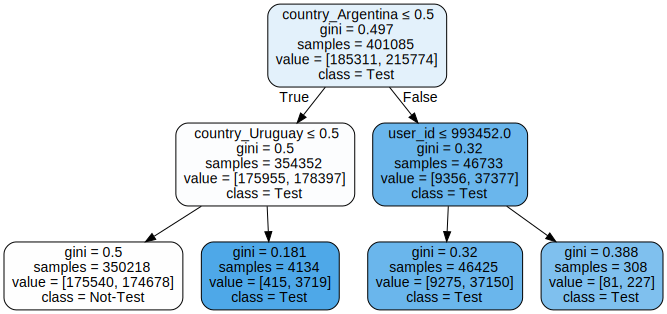

In [29]:
dot_data = tree.export_graphviz(clf, out_file=None, feature_names = X.columns,
                               class_names = ['Not-Test', 'Test'],
                               filled=True, rounded=True,
                               special_characters=True)
graphviz.Source(dot_data)

Interestingly, Argentina and Uruguay seem to be very strong predictors of whether or not the user will be in the "test" class.

Next step is to redo hypothesis test by each country

### 8. Hypothesis test (z-test) for difference of proportions, split by country

In [30]:
conversion_test_country = df[df.spain == 0].groupby(['country', 'test']).conversion.agg(['count', 'mean']).unstack()
conversion_test_country

count             mean          
test             0      1         0         1
country                                      
Argentina     9356  37377  0.015071  0.013725
Bolivia       5550   5574  0.049369  0.047901
Chile         9853   9884  0.048107  0.051295
Colombia     27088  26972  0.052089  0.050571
Costa Rica    2660   2649  0.052256  0.054738
Ecuador       8036   7859  0.049154  0.048988
El Salvador   4108   4067  0.053554  0.047947
Guatemala     7622   7503  0.050643  0.048647
Honduras      4361   4207  0.050906  0.047540
Mexico       64209  64275  0.049495  0.051186
Nicaragua     3419   3304  0.052647  0.054177
Panama        1966   1985  0.046796  0.049370
Paraguay      3650   3697  0.048493  0.049229
Peru         16869  16797  0.049914  0.050604
Uruguay        415   3719  0.012048  0.012907
Venezuela    16149  15905  0.050344  0.048978

In [31]:
ctc = conversion_test_country
ctc['p-value'] = np.vectorize(prop_test)(ctc.iloc[:,0], ctc.iloc[:,1], ctc.iloc[:,2], ctc.iloc[:,3])
ctc = ctc.sort_values(by='p-value')
ctc

count             mean             p-value
test             0      1         0         1          
country                                                
Mexico       64209  64275  0.049495  0.051186  0.082772
El Salvador   4108   4067  0.053554  0.047947  0.124099
Chile         9853   9884  0.048107  0.051295  0.151423
Argentina     9356  37377  0.015071  0.013725  0.160878
Colombia     27088  26972  0.052089  0.050571  0.211862
Honduras      4361   4207  0.050906  0.047540  0.235832
Guatemala     7622   7503  0.050643  0.048647  0.286068
Venezuela    16149  15905  0.050344  0.048978  0.286863
Costa Rica    2660   2649  0.052256  0.054738  0.343898
Panama        1966   1985  0.046796  0.049370  0.352637
Bolivia       5550   5574  0.049369  0.047901  0.359424
Peru         16869  16797  0.049914  0.050604  0.385971
Nicaragua     3419   3304  0.052647  0.054177  0.390156
Uruguay        415   3719  0.012048  0.012907  0.441389
Paraguay      3650   3697  0.048493  0.049229  0.441841
Ecuador       8036   7859  0.049154  0.048988  0.480755

## Conclusion

After redoing the analysis for each country, we see that actually none of the p-values are significant. Mexico comes close -- which makes sense due to the very large sample size. However, the size of effect is relatively small. Given the size of effect and p-value, none of these tests give a strong argument to reject the null hypothesis.

It's not the good news we were hoping for, since the localized translations were hoping to improve conversion rate, but at least with these results we know that they were not detrimental to conversion.

The code that groups conversion rate and count by country, and then applys a z-test to each row is an "algorithm" that could be used to automate this process in the future.